In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import PyPDF2
import os
import re

## 1. Load data

In [2]:
CORPUS_DIR = 'corpus'
corpus = ""
for file in os.listdir(CORPUS_DIR):
    if file.endswith('.pdf'):
        path_pdf = os.path.join(CORPUS_DIR, file)
        with open(path_pdf, 'rb') as path_pdf:
            lecteur_pdf = PyPDF2.PdfReader(path_pdf)
            for page in lecteur_pdf.pages:
                corpus += page.extract_text()

#### Tokenization

In [3]:
def preprocess(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
words = preprocess(corpus)

In [4]:
#We 'll use a skipgram with 2 outside word (1center word + 2 outside words)
n = len(words.split())//3
words = words[0:n]

In [5]:
vocab = list(set(words.split()))
vocab.append('<UNK>')

In [6]:
word2index = {v : k for k,v in enumerate(vocab)}
index2word = {v : k for k,v in word2index.items()}

## 2. Prepare tain data

In [7]:
#We use a skipgram with 2 outside word (1center word + 2 outside words)
l = words.split()
docs = [l[i:i + 3] for i in range(0, len(l))]

In [8]:
def random_batch(batch_size, docs) : 
    #create pairs of center word and outside words
    skipgrams = []
    
    #loop each corpus
    for doc in docs : 
        #loop each document
        for i in range(1, len(doc)-1) :
            center = word2index[doc[i]] #center word
            outside = (word2index[doc[i-1]], word2index[doc[i+1]]) #2 outside words
    
            for each_outside in outside : 
                skipgrams.append([center,each_outside]) 
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace = False)
    inputs, labels = [],[]
    for i in random_index : 
        inputs.append([skipgrams[i][0]])
        labels.append([skipgrams[i][1]])

    return np.array(inputs), np.array(labels)

## 3. Model

In [9]:
vocab_size = len(vocab)
embed_size = 250
batch_size=64

In [32]:
class Skipgram(nn.Module) : 
    def __init__(self, vocab_size, embed_size):
        super(Skipgram, self).__init__()
        self.embedding_center = nn.Embedding(vocab_size, embed_size)
        self.embedding_outside = nn.Embedding(vocab_size, embed_size)
    
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)


    def forward(self, center, outside, all_vocabs):
        assert torch.all(center < vocab_size), "Center indices are out of range."
        assert torch.all(outside < vocab_size), "Outside indices are out of range."
    
        center_embedding = self.embedding_center(center)
        outside_embedding = self.embedding_outside(outside)
    
        assert not torch.any(torch.isnan(center_embedding)), "NaN in center_embedding after embedding lookup"
        assert not torch.any(torch.isnan(outside_embedding)), "NaN in outside_embedding after embedding lookup"
    
        all_vocabs_embedding = self.embedding_center(all_vocabs)
    
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
    
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)
    
        # Clipping
        top_term = torch.clamp(top_term, min=1e-10, max=1e10)
        lower_term_sum = torch.clamp(lower_term_sum, min=1e-10, max=1e10)
    
        loss = -torch.mean(torch.log(top_term / lower_term_sum))
        return loss
        

In [33]:
def prepare_sequence(seq, word2index) : 
    idxs = list(map(lambda w : word2index[w] if word2index[w] is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(vocab, word2index).expand(batch_size, vocab_size)

In [34]:
model = Skipgram(vocab_size, batch_size)
model

Skipgram(
  (embedding_center): Embedding(5754, 64)
  (embedding_outside): Embedding(5754, 64)
)

In [35]:
input_batch, label_batch = random_batch(batch_size, docs)
input_tensor = torch.LongTensor(input_batch)
label_tensor = torch.LongTensor(label_batch)
#predict
model(input_tensor, label_tensor, all_vocabs)

tensor(8.6574, grad_fn=<NegBackward0>)

## 3. Training

In [36]:
vocab_size = len(vocab)
embed_size = 250
batch_size=64
num_epochs = 5000

In [37]:
model = Skipgram(vocab_size,embed_size)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [38]:
for epoch in range(num_epochs) : 
    #get_branch
    input_batch, label_batch = random_batch(batch_size, docs)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()

    #print the loss
    if (epoch+1)%100 == 0 :
        print(f"Epoch {epoch+1} | Loss : {loss}")

Epoch 100 | Loss : 8.657668113708496
Epoch 200 | Loss : 8.655233383178711
Epoch 300 | Loss : 8.649447441101074
Epoch 400 | Loss : 8.650864601135254
Epoch 500 | Loss : 8.647501945495605
Epoch 600 | Loss : 8.631904602050781
Epoch 700 | Loss : 8.624281883239746
Epoch 800 | Loss : 8.635309219360352
Epoch 900 | Loss : 8.601694107055664
Epoch 1000 | Loss : 8.576281547546387
Epoch 1100 | Loss : 8.573761940002441
Epoch 1200 | Loss : 8.526155471801758
Epoch 1300 | Loss : 8.547469139099121
Epoch 1400 | Loss : 8.500836372375488
Epoch 1500 | Loss : 8.41303825378418
Epoch 1600 | Loss : 8.422750473022461
Epoch 1700 | Loss : 8.36768913269043
Epoch 1800 | Loss : 8.359460830688477
Epoch 1900 | Loss : 8.295373916625977
Epoch 2000 | Loss : 8.255903244018555
Epoch 2100 | Loss : 8.267858505249023
Epoch 2200 | Loss : 8.222728729248047
Epoch 2300 | Loss : 8.244621276855469
Epoch 2400 | Loss : 8.204507827758789
Epoch 2500 | Loss : 8.275622367858887
Epoch 2600 | Loss : 8.308748245239258
Epoch 2700 | Loss : 8.2

In [41]:
def get_embed(word) : 
    try : 
        index = word2index[word]
    except : index = word2index['<UNK>']

    word = torch.LongTensor([index])
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed = (embed_c+embed_o)/2
    return embed

In [42]:
get_embed('bonjour')

tensor([[ 0.0339,  0.0318,  0.0449,  0.0133,  0.0252,  0.0221, -0.0368, -0.0387,
         -0.0104,  0.0180, -0.0237,  0.0219,  0.0319,  0.0306, -0.0178,  0.0030,
          0.0162,  0.0466, -0.0481,  0.0515,  0.0205, -0.0109,  0.0260,  0.0211,
          0.0403,  0.0010,  0.0396,  0.0149, -0.0565, -0.0290,  0.0179, -0.0251,
          0.0561,  0.0179, -0.0536,  0.0304,  0.0416,  0.0131,  0.0243, -0.0091,
          0.0183,  0.0080,  0.0060,  0.0369,  0.0242,  0.0083,  0.0205, -0.0116,
          0.0031, -0.0071, -0.0093, -0.0250, -0.0002,  0.0102, -0.0355,  0.0271,
         -0.0073, -0.0448, -0.0115, -0.0095,  0.0169, -0.0482, -0.0047,  0.0119,
         -0.0185,  0.0042, -0.0326,  0.0068, -0.0242,  0.0322, -0.0211, -0.0483,
         -0.0274, -0.0279,  0.0163,  0.0233,  0.0046,  0.0096,  0.0447,  0.0550,
         -0.0271, -0.0166,  0.0382, -0.0360, -0.0310,  0.0316, -0.0222, -0.0069,
         -0.0255,  0.0107,  0.0427,  0.0259,  0.0282, -0.0121, -0.0166,  0.0013,
          0.0117, -0.0110,  

In [45]:
embeddings = model.embedding_center.weight.data.numpy()  

In [51]:
from sklearn.manifold import TSNE

In [52]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

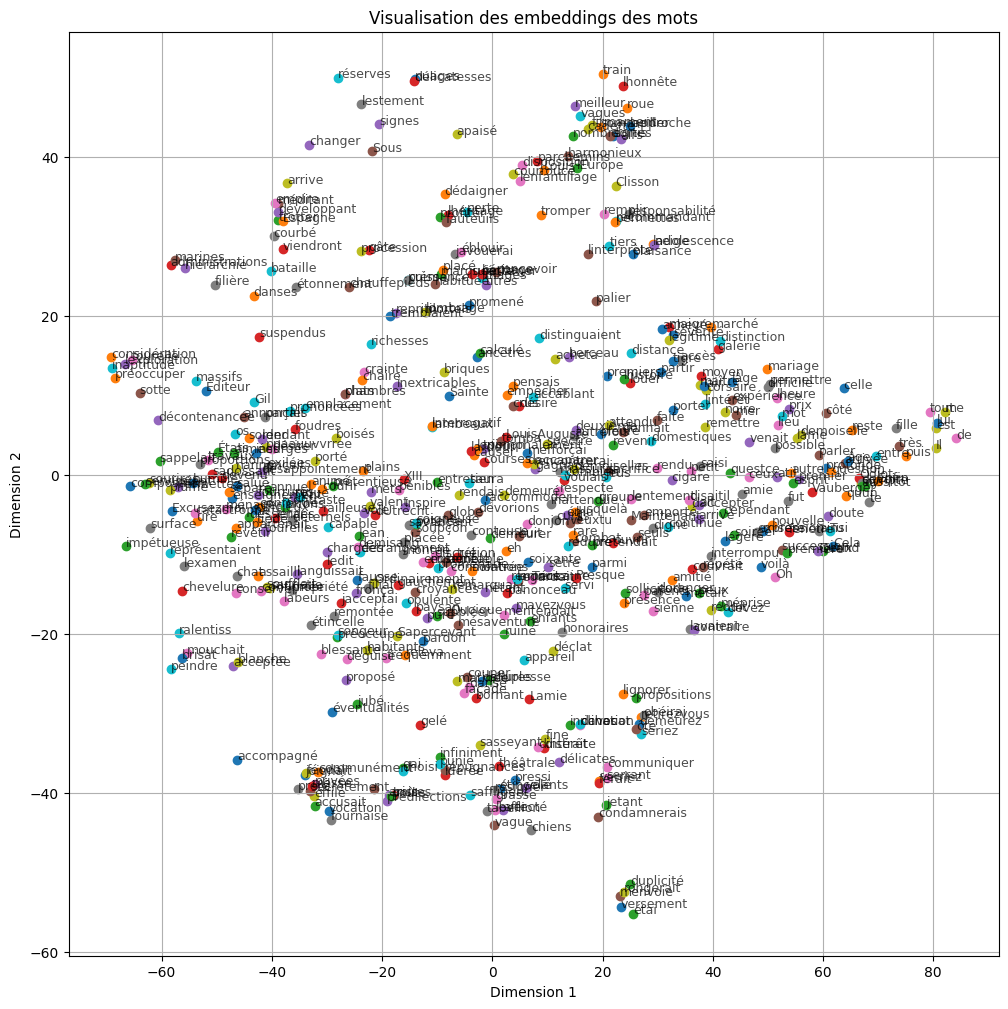

In [61]:
num_words = min(len(words), embeddings_2d.shape[0]) 

plt.figure(figsize=(12, 12))
for i in range(500):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(vocab[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9, alpha=0.7)

plt.title('Visualisation des embeddings des mots')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()